<a href="https://colab.research.google.com/github/DanielPopoola/data-science-projects/blob/main/SafariCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Projects/data-science-projects')
os.getcwd()

'/content/drive/MyDrive/Projects/data-science-projects'

In [3]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.0.1+cu118


## View the data

4 classes:
['elephant', 'giraffe', 'lion', 'zebra']


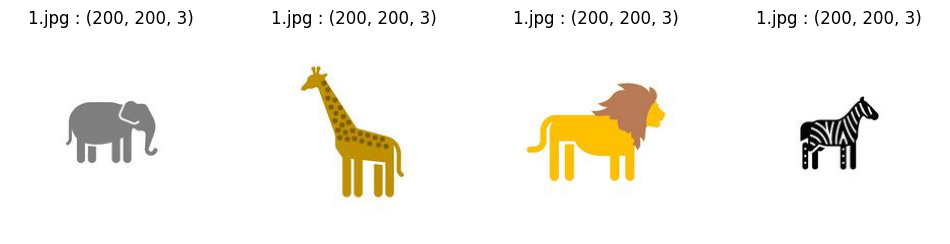

In [4]:
# The images are in the data/shapes folder
data_path = 'datasets/safari/training'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(12, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file + ' : ' + str(img_shape))
plt.show()

## Load the data

In [11]:
def load_dataset(data_path):
  # Define transformation variable
  transformation = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
  ])
  # Load the dataset
  full_dataset = torchvision.datasets.ImageFolder(
      root = data_path,
      transform = transformation
  )

  # Split the dataset 70% - 30%
  train_size = int(0.7 * len(full_dataset))
  test_size = len(full_dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_size, test_size])

  # Define a train loader and test loader for loading images in 50-batches
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size = 50,
      num_workers = 0,
      shuffle = False
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=50,
      num_workers = 0,
      shuffle = False
  )

  return train_loader, test_loader

Run the load_dataset function

In [12]:
train_loader, test_loader = load_dataset(data_path)
print('Data Loaders ready!')

Data Loaders ready!


## Define the CNN class

In [20]:
class Safari(nn.Module):
  def __init__(self, num_classes=4):
    super(Safari,self).__init__()
    # Define the convolution layers and the pooling method
    self.conv1 = nn.Conv2d(in_channels= 3,out_channels=12,kernel_size=3,stride=1,padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2)

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)

    self.conv3 = nn.Conv2d(in_channels=12, out_channels =24, kernel_size=3, stride=1, padding=1)

    # Define a drop layer to prevent over-fitting
    self.drop = nn.Dropout2d(p=0.2)

    # Flatten the features
    self.fc = nn.Linear(in_features=50 * 50 * 24,  out_features=num_classes)

  def forward(self, x):
    x = F.relu(self.pool(self.conv1(x)))

    x = F.relu(self.pool(self.conv2(x)))

    x = F.relu(self.drop(self.conv3(x)))

    x = F.dropout(x, training = self.training)

    x = x.view(-1, 50 * 50 * 24)
    # Feed to fully-connected layer to predict class
    x = self.fc(x)
    # Return log_softmax tensor 
    return F.log_softmax(x, dim=1)
    
print("Safari model class defined!")


Safari model class defined!


## Define training and testing functions

In [21]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  train_loss = 0
  print("Epoch:", epoch)
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    output = model(data)

    loss = loss_criteria(output, target)

    train_loss += loss.item()

    loss.backward()
    optimizer.step()

    # Print metrics for every 10 batches so we see some progress
    if batch_idx % 10 == 0:
      print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
          batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
            
  # return average loss for the epoch
  avg_loss = train_loss / (batch_idx+1)
  print('Training set: Average loss: {:.6f}'.format(avg_loss))
  return avg_loss
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    


## Train and predict

In [22]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Safari(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 5
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/277 (0%)] Loss: 1.410796
Training set: Average loss: 1.406485
Validation set: Average loss: 0.826454, Accuracy: 85/119 (71%)

Epoch: 2
Training set [0/277 (0%)] Loss: 0.953766
Training set: Average loss: 0.548063
Validation set: Average loss: 0.152053, Accuracy: 119/119 (100%)

Epoch: 3
Training set [0/277 (0%)] Loss: 0.358020
Training set: Average loss: 0.136298
Validation set: Average loss: 0.011464, Accuracy: 119/119 (100%)

Epoch: 4
Training set [0/277 (0%)] Loss: 0.041551
Training set: Average loss: 0.025454
Validation set: Average loss: 0.000730, Accuracy: 119/119 (100%)

Epoch: 5
Training set [0/277 (0%)] Loss: 0.010577
Training set: Average loss: 0.006202
Validation set: Average loss: 0.000265, Accuracy: 119/119 (100%)



## Evaluate model performance

Getting predictions from test set...


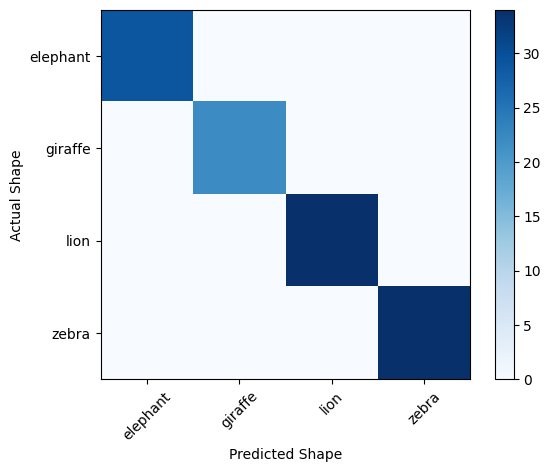

In [23]:
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Save the model

In [24]:
model_file = 'models/animal_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/animal_classifier.pt


## Use trained model

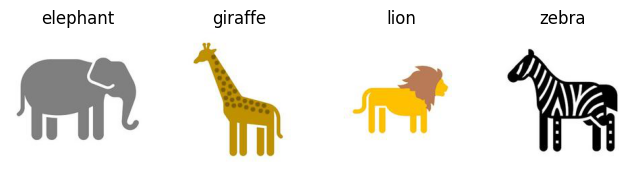

In [27]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Default value
    index = 0
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Load your model
model = Safari()
model.load_state_dict(torch.load(model_file))

# The images are in the data/shapes folder
test_data_path = 'datasets/safari/test'

# Show the test images with predictions
fig = plt.figure(figsize=(8, 12))
i = 0
for img_file in os.listdir(test_data_path):
    i+=1
    img_path = os.path.join(test_data_path, img_file)
    img = mpimg.imread(img_path)
    # Get the image class prediction
    index = predict_image(model, np.array(img))
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes[index])
plt.show()